In [17]:
import sys
sys.path.append("../sunderseaice")

import h5py
import xarray as xr
import cftime
import pandas as pd

from readers.icesat2 import load_atl20_month

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
fp = "/home/apbarret/Data/ICESat-2/ATL20/ATL20-01_20181101001332_05100101_001_01.h5"

In [47]:
def _maybe_decode_bytes(txt):
    if isinstance(txt, bytes):
        return txt.decode("utf-8")
    else:
        return txt
    

def _read_attributes(h5dataset):
    """Returns a dict of attributes for an H5 dataset"""
    attrs = {}
    for k, v in h5dataset.attrs.items():
        if k not in ["_FillValue", "missing_value"]:
            v = _maybe_decode_bytes(v)
        attrs[k] = v
    return attrs


def get_crs(fh):
    """Returns dict of crs values"""
    if "crs" not in fh.keys():
        raise KeyError("crs not attribute of {fh.filename}")
    return _read_attributes(fh['crs'])  # May need to add logic to decode bytes


def _read_dataset(h5dataset):
    """Returns a H5 dataset as xarray.DataArray"""
    if not isinstance(h5dataset, h5py.Dataset):
        raise TypeError(f"Expects h5py.Dataset, got {h5dataset} instead")
    attrs = _read_attributes(h5dataset)
    if len(h5dataset.shape) > 1:
        dims=('grid_y', 'grid_x')
    else:
        if h5dataset.shape[0] == 304: 
            dims = ('grid_x')
        elif h5dataset.shape[0] == 448:
            dims = ('grid_y')
        else:
            raise ValueError("Unknown dimensions")
    da = xr.DataArray(h5dataset[::], dims=dims, attrs=attrs)
    if "_FillValue" in da.attrs:
        da = da.where(da < da.attrs["_FillValue"])
    return da

def _read_time(h5time_dataset):
    attrs = _read_attributes(h5time_dataset)
    value = h5time_dataset[::]
    time = cftime.num2date(value[0], attrs["units"]).isoformat()
    return xr.DataArray([pd.to_datetime(time)], dims=['time'], attrs=attrs)


def _read_daygroup(h5group):
    """Reads day group and returns as xarray.Dataset"""
    dataset_dict = {}
    for h5name, h5dataset in h5group.items():
        if h5name in ["delta_time_beg", "delta_time_end"]:
            dataset_dict[h5name] = _read_time(h5dataset)
        else:
            dataset_dict[h5name] = _read_dataset(h5dataset).expand_dims('time')
    ds = xr.Dataset(dataset_dict)
    ds["time"] = ds.delta_time_beg.dt.ceil("12H")
    return ds
    
    
def _read_dailygroup(fh):
    if 'daily' not in fh.keys():
        raise KeyError(f"daily not a group in {fh}")
    day_list = []
    for day_group in fh['daily'].values():
        day_list.append(_read_daygroup(day_group))
    return xr.concat(day_list, dim="time")


def _read_ancillary(fh):
    ancillary_variables = {}
    for key, item in fh.items():
        if key in ['grid_lat', 'grid_lon', 'grid_x', 'grid_y', 'land_mask_map']:
            ancillary_variables[key] = _read_dataset(item)
    return xr.Dataset(ancillary_variables)


def read_atl20(filepath):
    with h5py.File(filepath, "r") as fh:
        crs_attrs = get_crs(fh)
        ancillary_ds = _read_ancillary(fh)  # Get coord and ancillary variables
        daily_ds = _read_dailygroup(fh)
        
    attrs = crs_attrs 
    ds = xr.merge([ancillary_ds, daily_ds])
    ds.attrs = crs_attrs
    return ds

In [48]:
ds = read_atl20(fp)
ds

<xarray.Dataset>
Dimensions:         (grid_x: 304, grid_y: 448, time: 30)
Coordinates:
  * grid_x          (grid_x) float64 -3.838e+06 -3.812e+06 ... 3.738e+06
  * grid_y          (grid_y) float64 5.838e+06 5.812e+06 ... -5.338e+06
  * time            (time) datetime64[ns] 2018-11-01T12:00:00 ... 2018-11-30T...
Data variables:
    grid_lat        (grid_y, grid_x) float64 31.1 31.2 31.3 ... 34.58 34.47
    grid_lon        (grid_y, grid_x) float64 -11.68 -11.85 ... 169.8 170.0
    land_mask_map   (grid_y, grid_x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    delta_time_beg  (time) datetime64[ns] 2018-11-01T02:07:53.417408 ... 2018...
    delta_time_end  (time) datetime64[ns] 2018-12-01T00:23:40.532282 ... 2018...
    length_sum      (time, grid_y, grid_x) float32 nan nan nan ... nan nan nan
    mean_fb         (time, grid_y, grid_x) float32 nan nan nan ... nan nan nan
    n_segs          (time, grid_y, grid_x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sigma           (time, grid_y, grid_x) float32 nan nan nan ... nan nan nan
Attributes:
    crs_wkt:                         "PROJCS["NSIDC Sea Ice Polar Stereograph...
    false_easting:                   0.0
    false_northing:                  0.0
    grid_mapping_name:               polar_stereographic
    inverse_flattening:              298.279411123061
    latitude_of_projection_origin:   90.0
    longitude_of_projection_origin:  -45.0
    proj4text:                       +proj=stere +lat_0=90 +lat_ts=70 +lon_0=...
    semi_major_axis:                 6378273.0
    srid:                            urn:ogc:def:crs:EPSG::3411
    standard_parallel:               70.0

In [40]:
b = ds.attrs["semi_major_axis"] - (ds.attrs["semi_major_axis"] / ds.attrs["inverse_flattening"])
globe = ccrs.Globe(semimajor_axis=ds.attrs["semi_major_axis"], semiminor_axis=b)
map_proj = ccrs.Stereographic(central_latitude=90., true_scale_latitude=70., central_longitude=-45.)

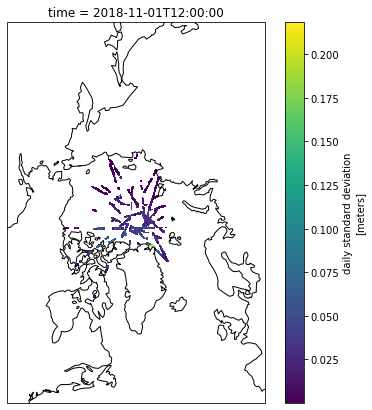

In [50]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=map_proj)
ax.set_extent([ds.grid_x.min(), ds.grid_x.max(), ds.grid_y.min(), ds.grid_y.max()], map_proj)
ax.coastlines()
ds["sigma"].isel(time=0).plot(ax=ax)